In [7]:
import cv2
import tkinter as tk
from tkinter import filedialog
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
import datetime
import scipy.stats as stats

### Import dataframe

In [30]:
#Import dataframes
df_metadata = pd.read_excel(r'F:\biodi_project\experiment_data\df_allfish_allexperiments.xlsx')
df_data = pd.read_excel(r'F:\biodi_project\analysis_dlc\video_analysis_network_3points\dataframe_results\df-long_results_5min-analysed_2023-10-25.xlsx')
df_pref_idx = pd.read_excel(r'F:\biodi_project\analysis_dlc\video_analysis_network_3points\dataframe_results\df_pref-index-results_5min-analysed_2023-10-25.xlsx')

### Select subjects to analyse

Choose some criteria and select the fish ID and experiment time, so to include only the selected sujects into the analysis

The main criteria used are: 
- fish that did not visit any choice area during the whole experiment (HAB+TEST) were escluded
- fish that spent 95% of time at HAB and 95% of time at TEST in the same choice area were excluded
- experiments that had problems were excluded
- only fish tested for the first time were included

In [31]:
#Select experiments and fish according to specific criteria
selector = (((df_metadata['correct_experiment'] == 'yes') | (df_metadata['correct_experiment'] == 'maybe')) &
            (df_metadata['first_exp'] == 'yes') & (df_metadata['exp_name'] == 'biodi') &
            (df_metadata['session'] == 'TEST'))
            
selected_subj = set(df_metadata.loc[selector, 'fish_ID'])
selected_dates = set(df_metadata.loc[selector, 'date'])

In [32]:
#Lists of values
exp_groups = list(sorted(set(df_data['exp_group'])))
fish_ids = list(set(df_data['fish_ID'].values))
#exp_date = list(sorted(set(df_data['date'].values)))

In [39]:
for i, group in enumerate(exp_groups):
        
    bool_selector = ((df_data['fish_ID'].isin(selected_subj)) & 
                     (df_data['date'].isin(selected_dates)) &
                     (df_data['exp_group'] == exp_groups[i]) & 
                     (df_data['session'] == 'TEST'))
    
    exp_tot_time = df_data[bool_selector]
    
    n_fish = len(exp_tot_time['fish_ID'].unique())
    
    print(group, 'number of fish tested:', n_fish)

exp1-flock-random1 number of fish tested: 8
exp1-flock-random2 number of fish tested: 9
exp1-flock-random2-speed8 number of fish tested: 9
exp1-random1-random2 number of fish tested: 9
exp2-n3-speed3-12 number of fish tested: 9
exp2-n3-speed3-6 number of fish tested: 10
exp2-n3-speed6-12 number of fish tested: 8
exp2-n6-speed3-12 number of fish tested: 14
exp2-n6-speed3-6 number of fish tested: 9
exp2-n6-speed6-12 number of fish tested: 9
exp3-n3-speed12-n6-speed6 number of fish tested: 9
exp3-n3-speed6-n6-speed3 number of fish tested: 9
exp3-n3-speed6-n6-speed6 number of fish tested: 16
exp4-realfish-empty number of fish tested: 9
expWRONG-exp3-n6-speed12-n6-speed12 number of fish tested: 3


In [38]:
len(exp_tot_time['fish_ID'].unique())

3

# Plots

#### Palette dictionary

In [12]:
#Palettes 

pubu = sns.color_palette('PuBu', 10)
blues = sns.color_palette(palette='Blues')
greens = sns.color_palette('Greens', 10)
greens_d = sns.color_palette(palette='Greens_d')
orgs = sns.color_palette(palette='Oranges')
y_orgs = sns.color_palette("YlOrBr")
purples = sns.color_palette(palette='Purples')
rpu = sns.color_palette(palette='RdPu')
prd = sns.color_palette(palette='PuRd')
grey = sns.color_palette(palette='Greys')

stimulus_colors = {
    'random1-n6-speed6': rpu[5],
    'random2-n6-speed6': prd[1], #tab20
    'random2-n6-speed8': purples[1],
    'flock-n6-speed8' : purples[5],
    
    'flock-n3-speed3' : blues[1],
    'flock-n3-speed6' : pubu[5],
    'flock-n3-speed12' : pubu[9],
    
    'flock-n6-speed3' : greens[3],
    'flock-n6-speed6' : greens[7],
    'flock-n6-speed12' : greens_d[5],
    
    'zebragroup-6wpf' : y_orgs[2],
    'empty-tank' : orgs[4]
}

exp_colors = {
    'exp1-flock-random1': rpu[5],
    'exp1-flock-random2': rpu[5],
    'exp1-random1-random2': rpu[5],                              
    'exp1-flock-random2-speed8': purples[5],
    
    'exp2-n6-speed3-12': greens_d[5],
    'exp2-n6-speed3-6': greens_d[5],
    'exp2-n6-speed6-12': greens_d[5],
    
    'exp2-n3-speed3-12' : pubu[5],
    
    'flock-n6-speed3' : greens[1],
    'flock-n6-speed6' : greens[3],
    'flock-n6-speed12' : greens_d[5],
    
     'exp3-n3-speed12-n6-speed6': grey[3],
     'exp3-n3-speed6-n6-speed3': grey[3],
     'exp3-n3-speed6-n6-speed6': grey[3],
     'exp4-realfish-empty': orgs[5],
     'expWRONG-exp3-n6-speed12-n6-speed12': grey[1]
}

### 1. Total time spent near each stimulus

Dictionary for labels 

In [13]:
label_dict = {'empty-tank':'Empty tank', 'zebragroup-6wpf': '6 zebrafish', 
              'random2-n6-speed8' : 'Random 2', 'random1-n6-speed8' : 'Random 1',
              'random2-n6-speed6' : 'Random 2', 'random1-n6-speed6' : 'Random 1', 
              'flock-n3-speed12' : 'Speed 3 cm/s', 'flock-n3-speed3' : 'Speed 0.75 cm/s',
              'flock-n6-speed12' : 'Speed 3 cm/s', 'flock-n6-speed3' : 'Speed 0.75 cm/s',
              'flock-n6-speed8': 'Shoal', 'flock-n6-speed6': 'Speed 1.5 cm/s', 
              'flock-n3-speed6': '3 dots speed 1.5 cm/s'}

#### Boxplots

In [14]:
#Data for saving figures
current_date = datetime.datetime.now()
folder_name = current_date.strftime("%Y-%m-%d")
folder_path = Path(rf"F:\biodi_project\experiment_data\figures\{folder_name}\boxplots")
folder_path.mkdir(parents=True, exist_ok=True)

In [18]:
tot_time_idx_one_asterics = ['exp1-flock-random1', 'exp2-n3-speed3-12', 'exp2-n6-speed3-12',
                             'exp2-n6-speed6-12', 'exp3-n3-speed6-n6-speed6', 'exp4-realfish-empty']

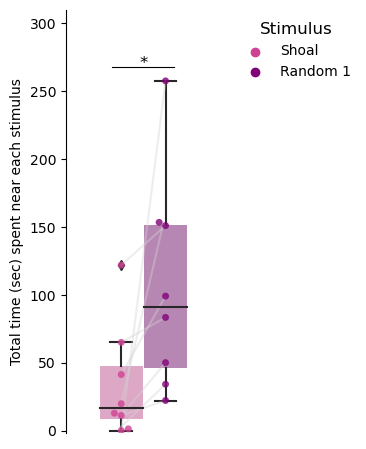

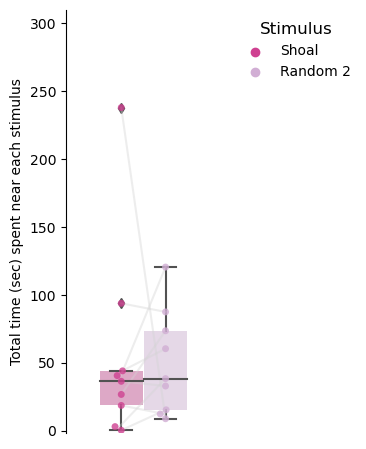

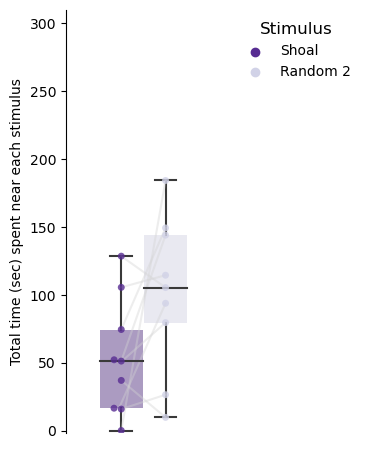

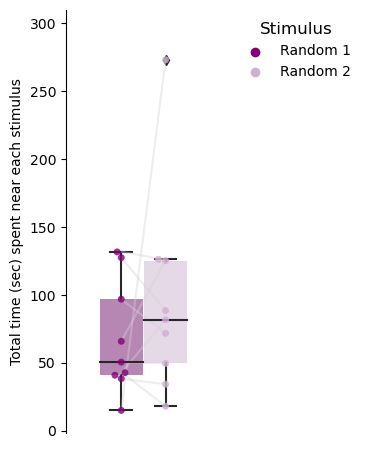

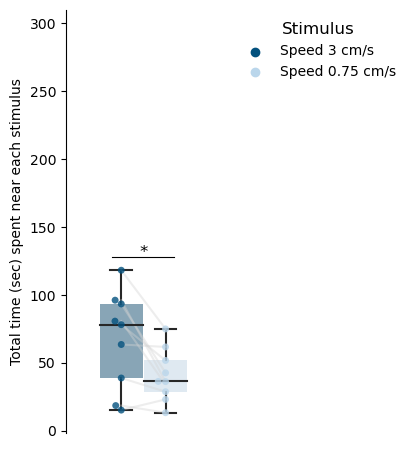

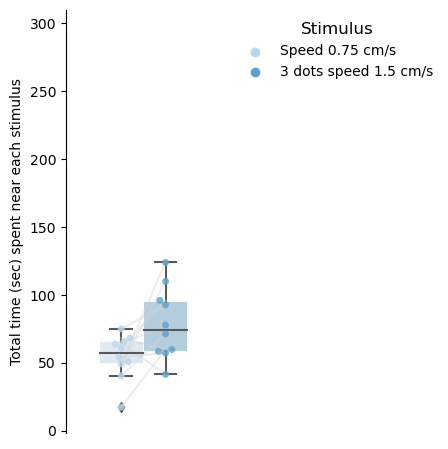

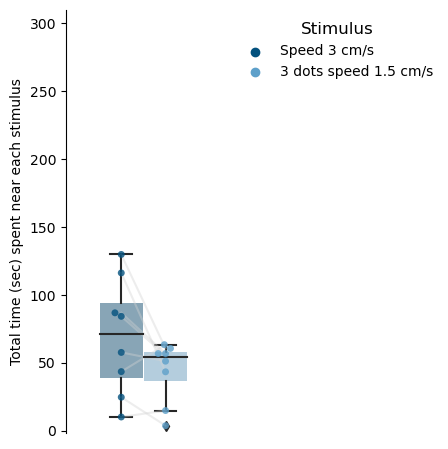

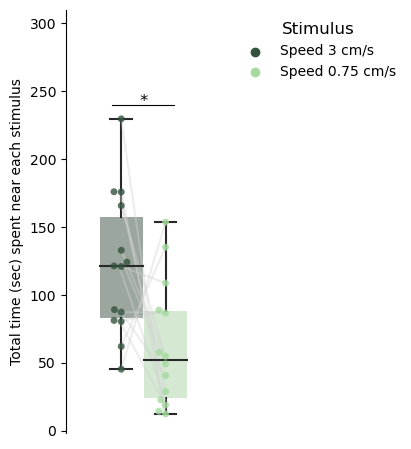

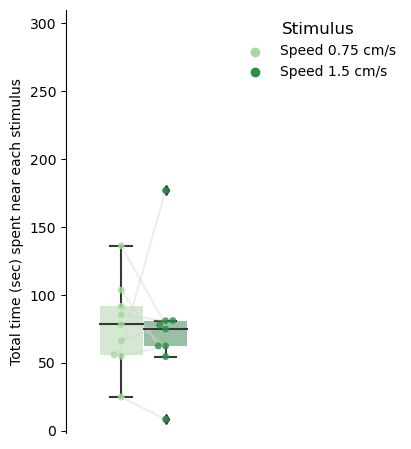

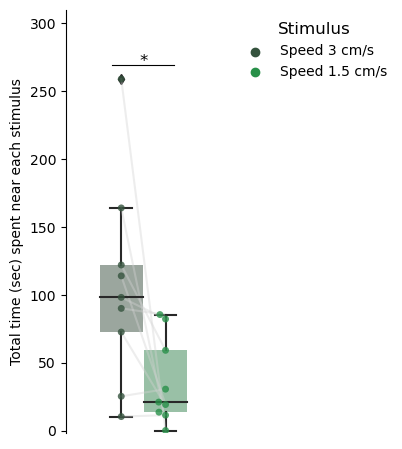

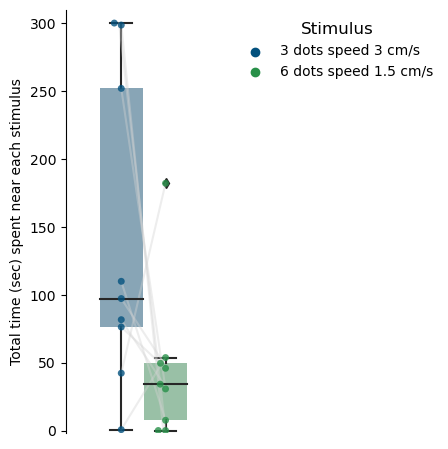

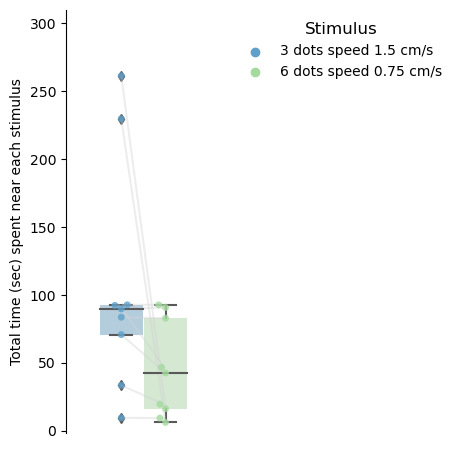

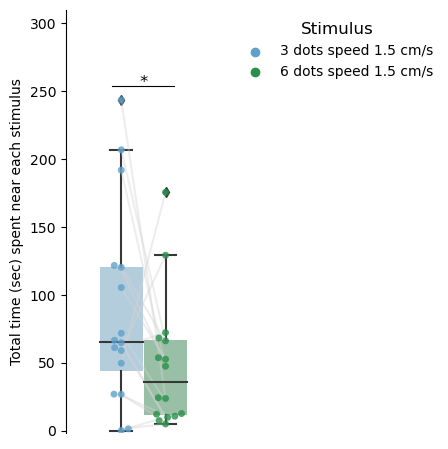

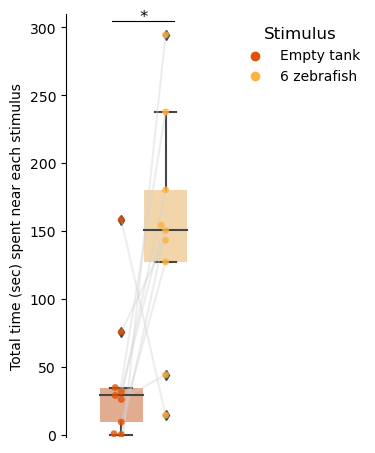

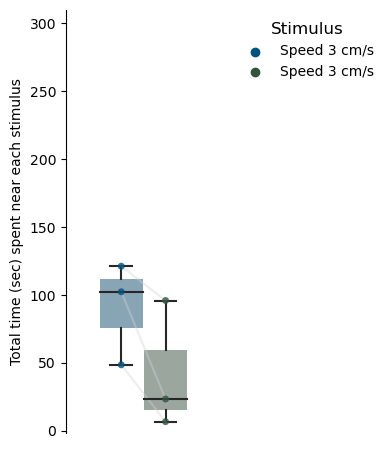

In [19]:
# Loop attraverso ciascun valore in exp_groups
# Specify the parent directory where you want to create the folder
# Get the current date

numeric_columns = ['tot_sec', 'minute1', 'minute2', 'minute3', 'minute4', 'minute5']

for i, group in enumerate(exp_groups):
    if (i == 0) or (i == 1):
        stimulus_colors['flock-n6-speed6'] = sns.color_palette(palette='PiYG')[0]
    else:
        stimulus_colors['flock-n6-speed6'] = greens[7]
        
    bool_selector = ((df_data['fish_ID'].isin(selected_subj)) & 
                     (df_data['date'].isin(selected_dates)) &
                     (df_data['exp_group'] == exp_groups[i]) & 
                     (df_data['session'] == 'TEST'))
    
    exp_tot_time = df_data[bool_selector]
    
    
    # Create the figure and axes
    f, ax = plt.subplots(figsize=(2, 5.5))
    
    # Create the swarm plot
    swarmplot = sns.swarmplot(data=exp_tot_time, x="session", y="tot_sec", hue="stimulus", dodge=True, 
                              alpha=0.8, palette=stimulus_colors)
    # Accessing individual dot positions
    x_positions = []
    y_positions = []

    # Iterate through the swarmplot collections
    for collection in swarmplot.collections:
        offsets = collection.get_offsets()
        x_positions.extend(offsets[:, 0])
        y_positions.extend(offsets[:, 1])

        # Create the boxplot with filled boxes and no edges
    boxplot = sns.boxplot(data=exp_tot_time, x="session", y="tot_sec", hue="stimulus", dodge=True, 
                          palette=stimulus_colors, boxprops={'edgecolor': 'None', 'alpha' : 0.5})
    #linewidth=0, showcaps=False, boxprops=dict(alpha=0.6)
    
    
    stimuli_values = exp_tot_time['stimulus'].unique()
    
    for fish_id in exp_tot_time['fish_ID'].unique():
        stim1_y = exp_tot_time[(exp_tot_time['stimulus'] == stimuli_values[0]) & (exp_tot_time['fish_ID'] == fish_id)]['tot_sec'].values[0]
        stim2_y = exp_tot_time[(exp_tot_time['stimulus'] == stimuli_values[1]) & (exp_tot_time['fish_ID'] == fish_id)]['tot_sec'].values[0]
    
    # Connect the dots for each fish using plt.plot()
        #plt.plot('TEST', [stim1_y, stim2_y], color='black', linestyle='-')
    
    n_fish = len(exp_tot_time['fish_ID'].unique())
    
    
    for d in range(n_fish):
        plt.plot([x_positions[d], x_positions[d+n_fish]], [y_positions[d], y_positions[d+n_fish]], color='lightgray',
                alpha=0.4)
    
    
    if group in tot_time_idx_one_asterics:
        
        y_coord = np.max(exp_tot_time['tot_sec']) + 10
        x_coord = 0   # Adjust this value as needed to position the line in the center of two boxplots

        plt.axhline(y=y_coord, xmin=0.3, xmax = 0.7, color='k', linewidth=0.8)
        plt.annotate('*', xy=(x_coord, y_coord), fontsize=12, ha='center')

        
    # Customize the legend
    handles, labels = ax.get_legend_handles_labels()
    
    legends = []
    exp1 = ['exp1-flock-random1', 'exp1-flock-random2','exp1-random1-random2']
    exp3 = ['exp3-n3-speed12-n6-speed6', 'exp3-n3-speed6-n6-speed3', 'exp3-n3-speed6-n6-speed6']
            
    for label in labels:
        if group in exp1:
            label_dict['flock-n6-speed6'] = 'Shoal'
        elif group in exp3:
            label_dict['flock-n6-speed6'] = '6 dots speed 1.5 cm/s'
            label_dict['flock-n3-speed12'] = '3 dots speed 3 cm/s'
            label_dict['flock-n3-speed6'] = '3 dots speed 1.5 cm/s'
            label_dict['flock-n6-speed3'] = '6 dots speed 0.75 cm/s'
        else:
            label_dict['flock-n6-speed6'] = 'Speed 1.5 cm/s'
            label_dict['flock-n3-speed12'] = 'Speed 3 cm/s'
            label_dict['flock-n6-speed3'] = 'Speed 0.75 cm/s'
        legends.append(label_dict[label])
    
    legend = ax.legend(handles[:2], legends[:2], bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
    legend.set_title("Stimulus", prop={'size':12})
    
    sns.despine(bottom=True)
    
    # Set labels and title
    ax.set(xlabel=None, ylabel="Total time (sec) spent near each stimulus", 
           title=None)
    ax.xaxis.set_ticks_position('none')
    ax.set_xticklabels([])
    
    plt.ylim(-2, 310)

        # Save the figure as a PDF file
    file_name = folder_path / f"boxplot_{exp_groups[i]}.pdf"
    #plt.savefig(file_name, bbox_inches='tight')
        

#### Barplots

In [20]:
#Data for saving figures
current_date = datetime.datetime.now()
folder_name = current_date.strftime("%Y-%m-%d")
folder_path = Path(rf"F:\biodi_project\experiment_data\figures\{folder_name}\barplots")
folder_path.mkdir(parents=True, exist_ok=True)

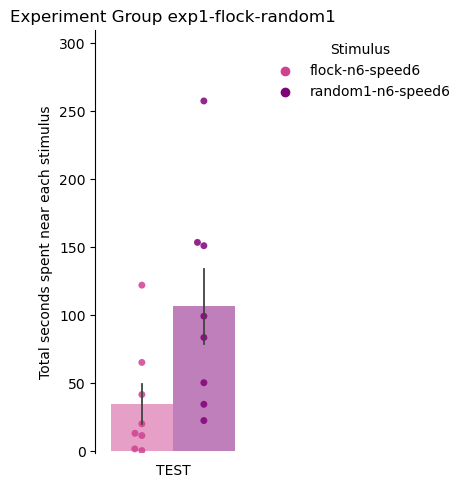

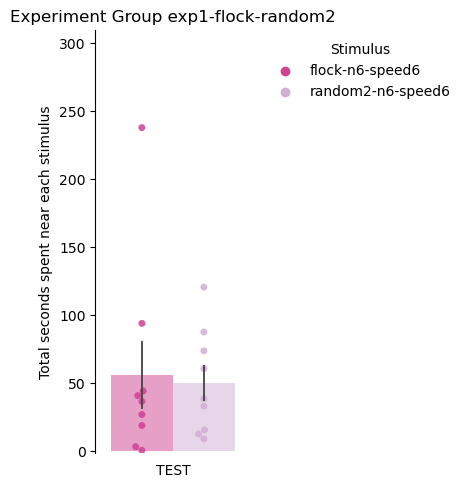

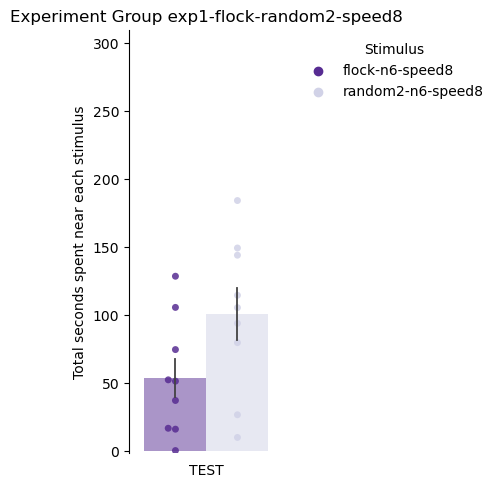

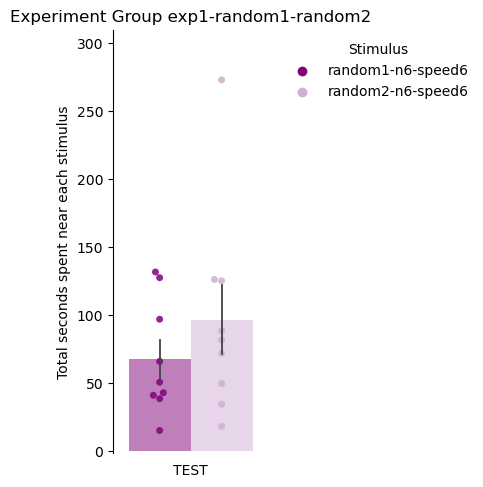

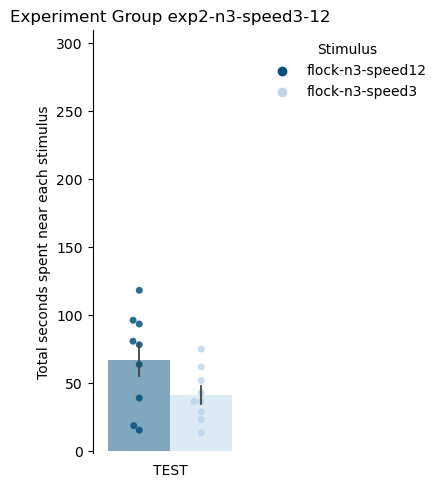

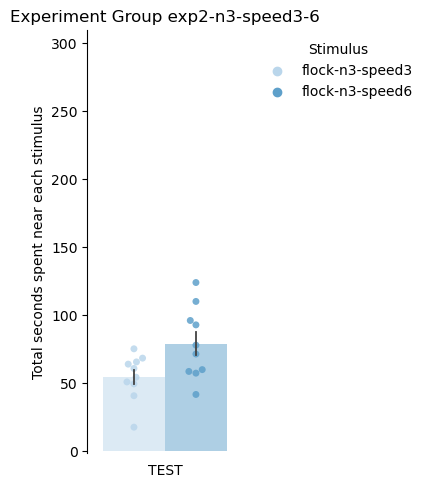

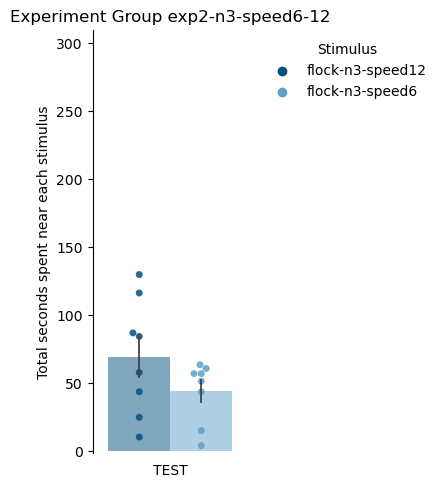

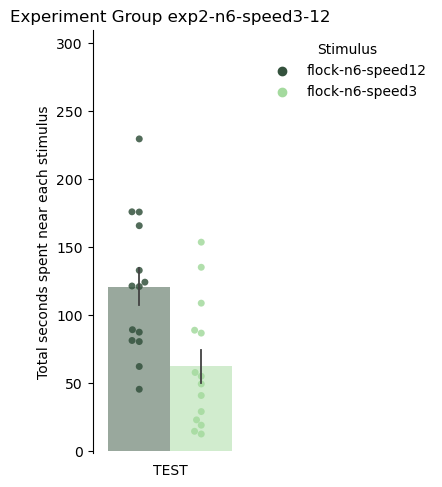

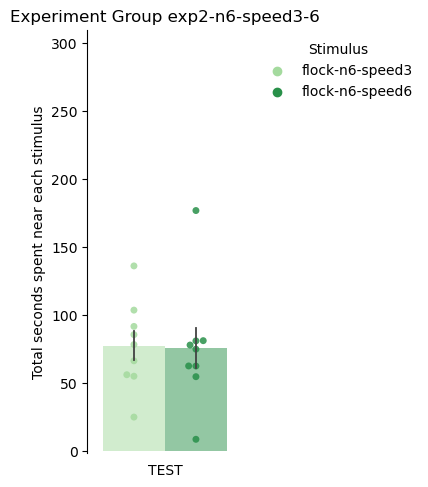

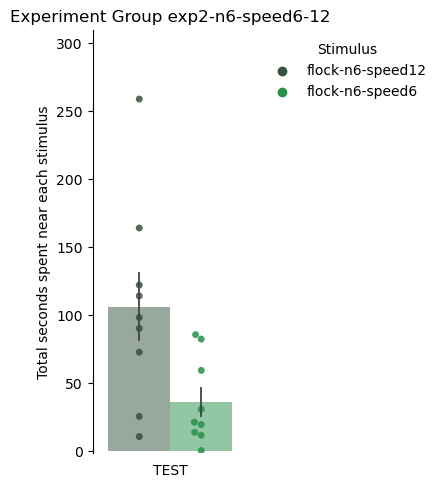

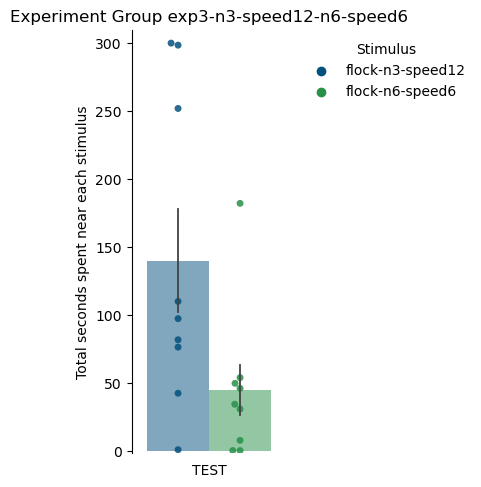

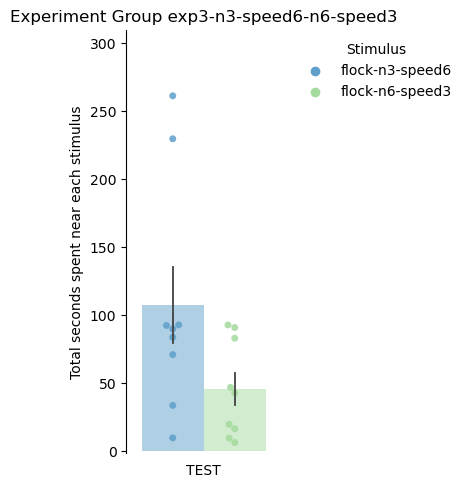

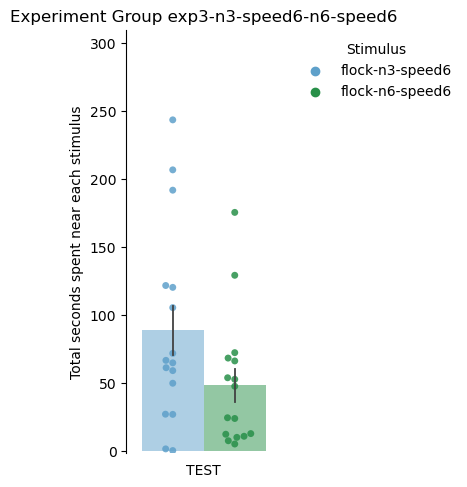

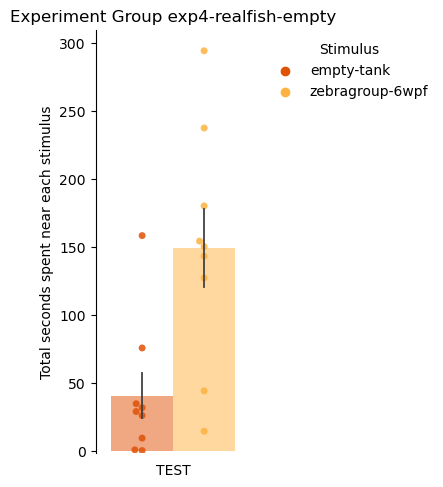

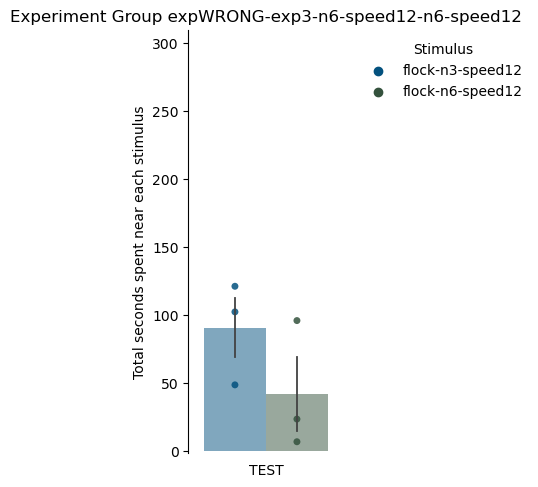

In [21]:
for i, group in enumerate(exp_groups):
    if (i == 0) or (i == 1):
        stimulus_colors['flock-n6-speed6'] = sns.color_palette(palette='PiYG')[0]
    else:
        stimulus_colors['flock-n6-speed6'] = greens[7]
        
    bool_selector = ((df_data['fish_ID'].isin(selected_subj)) & 
                     (df_data['date'].isin(selected_dates)) &
                     (df_data['exp_group'] == exp_groups[i]) &
                     (df_data['session'] == 'TEST'))
    
    exp_tot_time = df_data[bool_selector]
    
    # Create the figure and axes
    f, ax = plt.subplots(figsize=(2, 5.5))
    
    # Create the swarm plot
    swarmplot = sns.swarmplot(data=exp_tot_time, x="session", y="tot_sec", hue="stimulus", dodge=True, 
                              alpha=0.85, palette=stimulus_colors, zorder= -100)
    
    # Create the bar plot with custom edge colors
    barplot = sns.barplot(data=exp_tot_time, x="session", y="tot_sec", hue="stimulus", errorbar="se", 
                          dodge=True, capsize=0, errwidth=1.3, linewidth= 1.5, palette=stimulus_colors, alpha = 0.5)
    
    # Customize bar edge colors and face color
    for bars in ax.containers:
        stimulus = bars.get_label()  # Get the nationality from the container label
        for bar in bars:
            bar.set_edgecolor('None'), 
            bar.set_facecolor(stimulus_colors[stimulus])
    
    # Customize the legend
    handles, labels = ax.get_legend_handles_labels()
    legend = ax.legend(handles[:2], labels[:2], bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
    legend.set_title("Stimulus")
    
    sns.despine(bottom=True)
    
    # Set labels and title
    ax.set(xlabel=None, ylabel="Total seconds spent near each stimulus", 
           title=f"Experiment Group {exp_groups[i]}")
    ax.xaxis.set_ticks_position('none')
    
    plt.ylim(-2, 310)
    #plt.tight_layout()
    
    # Save the figure as a PDF file
    file_name = folder_path / f"barplot_{group}.pdf"
    #plt.savefig(file_name, bbox_inches='tight')

#### Time points - time spent near each stimulus across minutes

In [ ]:
#Data for saving figures
current_date = datetime.datetime.now()
folder_name = current_date.strftime("%Y-%m-%d")
folder_path = Path(rf"F:\biodi_project\experiment_data\figures\{folder_name}\timepoints_minutes")
folder_path.mkdir(parents=True, exist_ok=True)

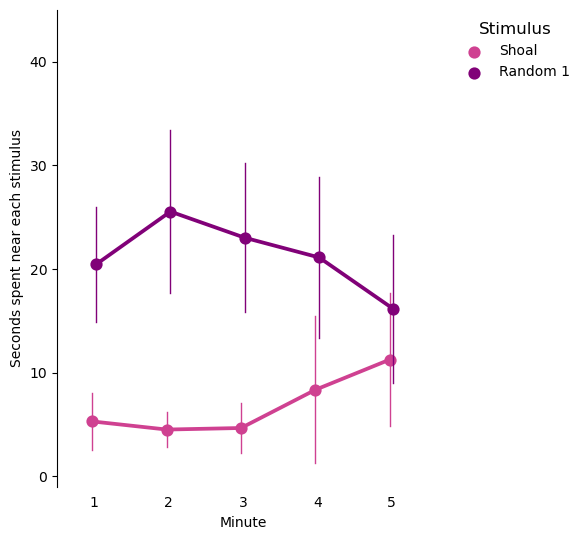

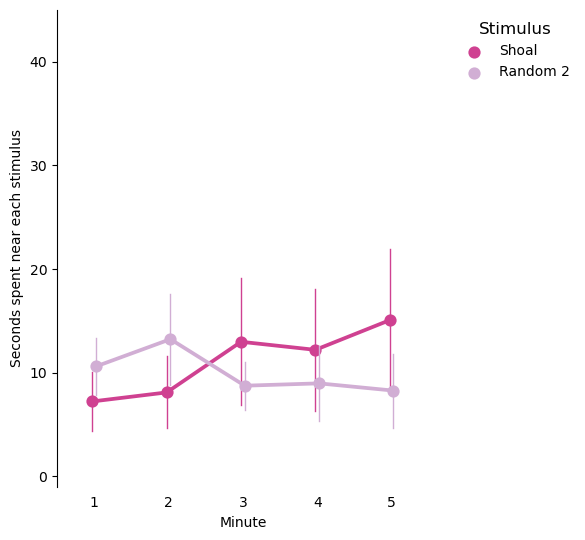

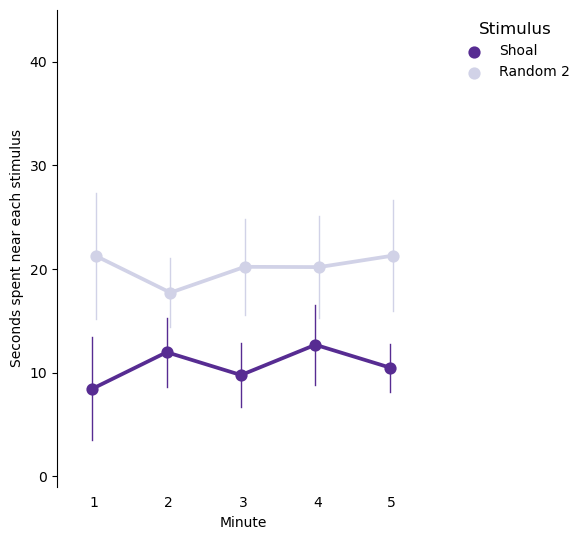

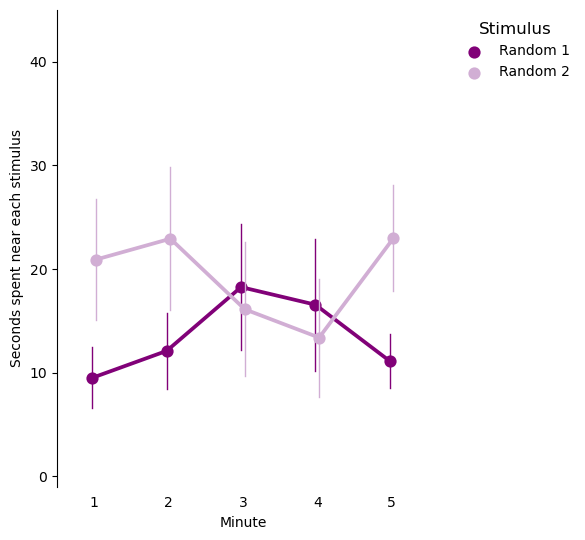

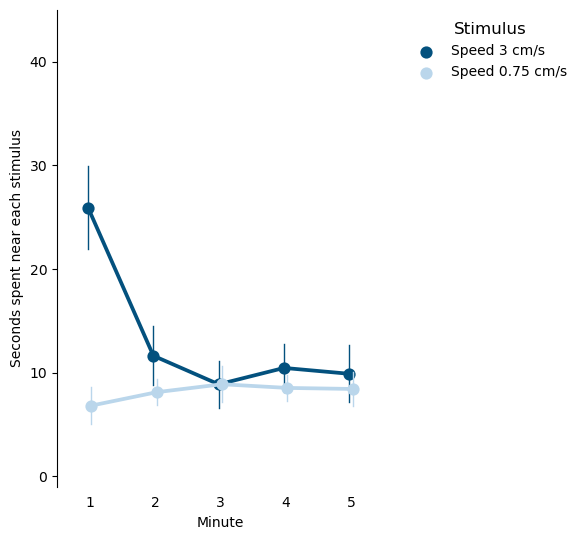

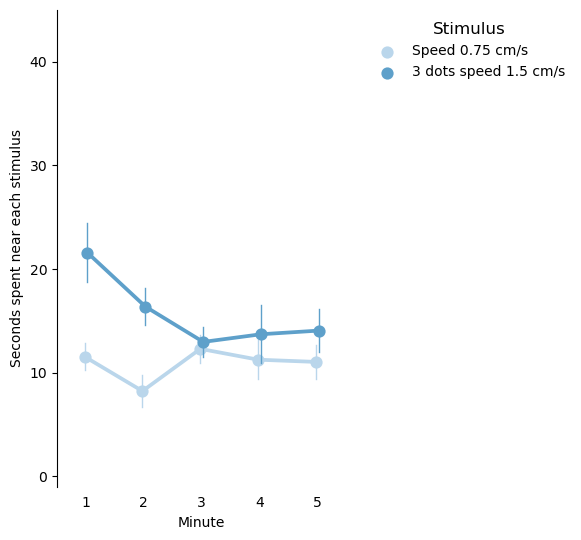

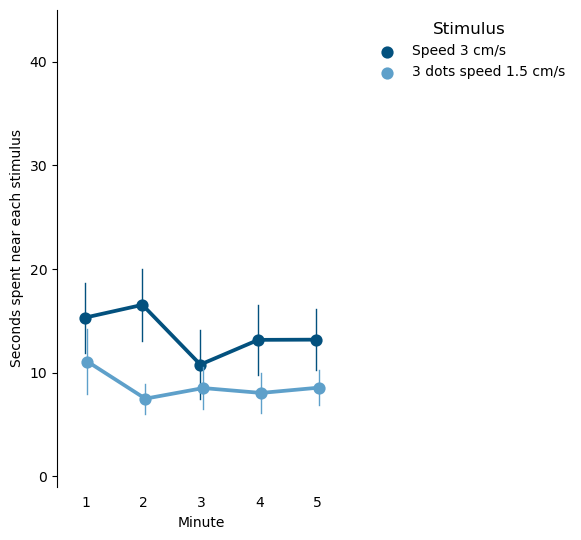

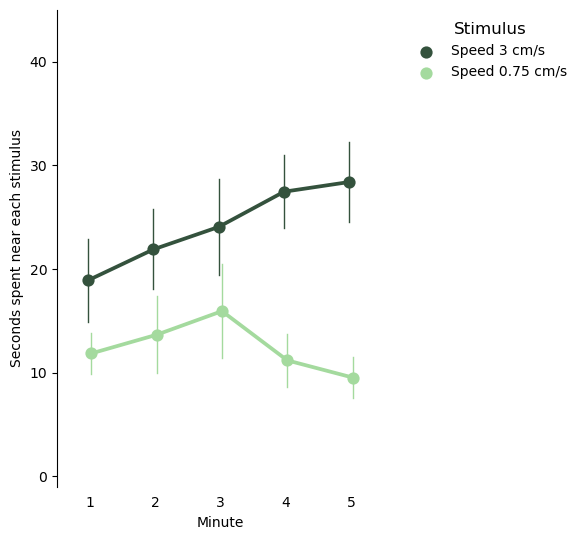

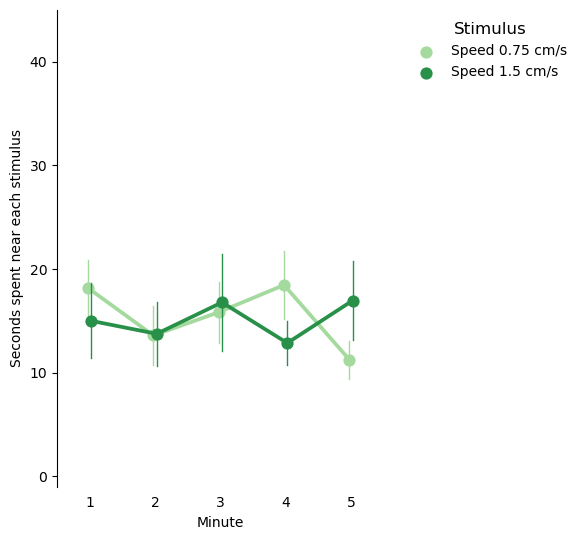

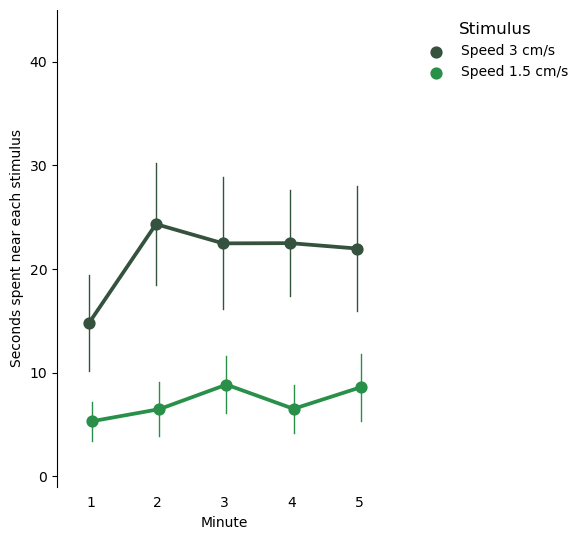

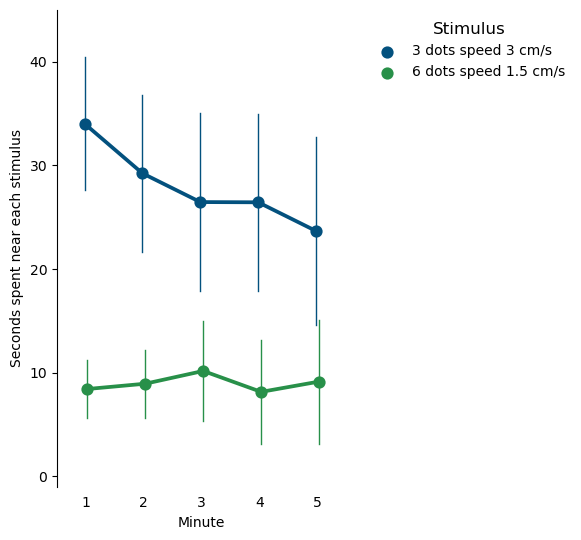

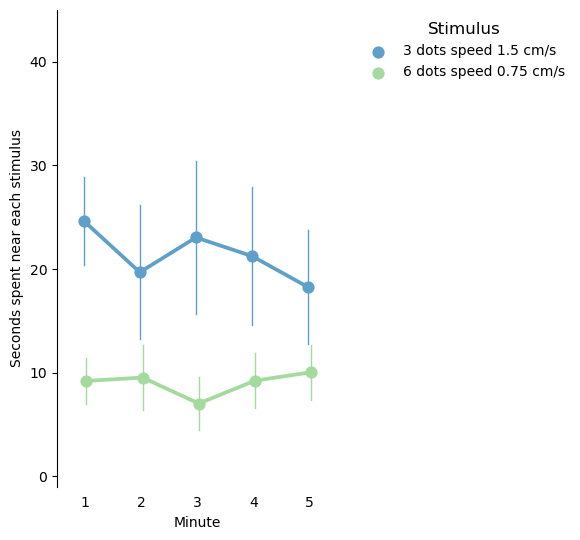

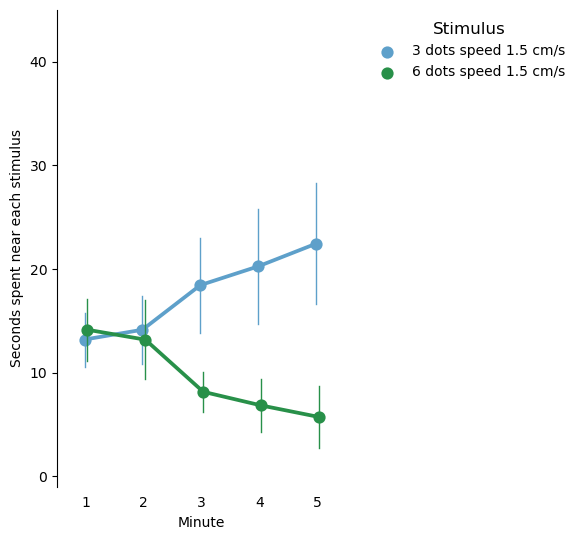

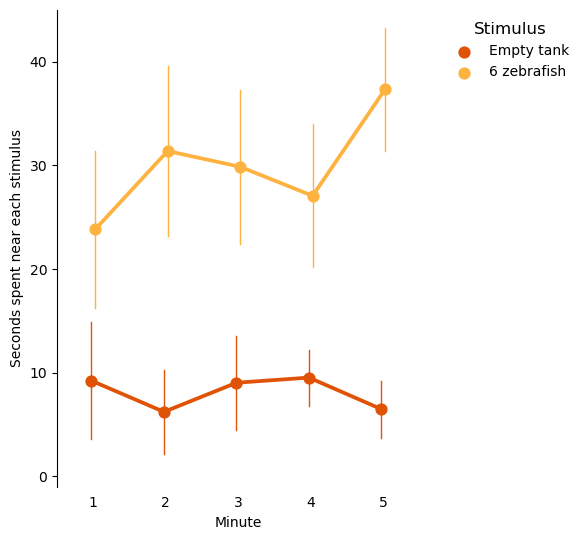

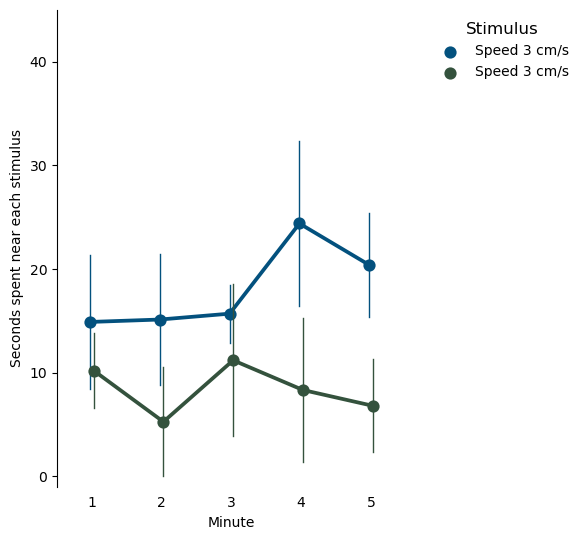

In [22]:
numeric_columns = ['tot_sec', 'minute1', 'minute2', 'minute3', 'minute4', 'minute5']

for i, group in enumerate(exp_groups):
    if (i == 0) or (i == 1):
        stimulus_colors['flock-n6-speed6'] = sns.color_palette(palette='PiYG')[0]
    else:
        stimulus_colors['flock-n6-speed6'] = greens[7]
       
    #Select data 
    bool_selector = ((df_data['fish_ID'].isin(selected_subj)) & 
                     (df_data['date'].isin(selected_dates)) &
                     (df_data['exp_group'] == exp_groups[i]) &
                     (df_data['session'] == 'TEST'))
    
    
    df_minutes = df_data[bool_selector]
    
    #Create a long format dataset
    df_long = pd.melt(df_minutes, id_vars=['exp_ID', 'date', 'exp_group', 'session', 'fish_ID', 'side', 'stimulus'], 
                  value_vars=['tot_sec','minute1', 'minute2', 'minute3', 'minute4', 'minute5'], var_name='timepoint')
    
    df_long = df_long.sort_values(['fish_ID', 'timepoint'])
    df_long = df_long[df_long['timepoint'] != 'tot_sec']
    mapping = {'minute1':1, 'minute2':2, 'minute3':3, 'minute4':4, 'minute5':5}
    df_long['timepoint'] = df_long['timepoint'].replace(mapping)
    
    # Create the figure and axes
    f, ax = plt.subplots(figsize=(6, 5.5))
    
    sns.pointplot(data=df_long, x="timepoint", y="value", hue="stimulus", errorbar="se", 
                  palette=stimulus_colors, dodge=True, join=True, errwidth=1, capsize=0)
    
    # Customize the legend
    handles, labels = ax.get_legend_handles_labels()
    
    legends = []
    exp1 = ['exp1-flock-random1', 'exp1-flock-random2','exp1-random1-random2']
    exp3 = ['exp3-n3-speed12-n6-speed6', 'exp3-n3-speed6-n6-speed3', 'exp3-n3-speed6-n6-speed6']
            
    for label in labels:
        if group in exp1:
            label_dict['flock-n6-speed6'] = 'Shoal'
        elif group in exp3:
            label_dict['flock-n6-speed6'] = '6 dots speed 1.5 cm/s'
            label_dict['flock-n3-speed12'] = '3 dots speed 3 cm/s'
            label_dict['flock-n6-speed3'] = '6 dots speed 0.75 cm/s'
            label_dict['flock-n3-speed6'] = '3 dots speed 1.5 cm/s'
        else:
            label_dict['flock-n6-speed6'] = 'Speed 1.5 cm/s'
            label_dict['flock-n3-speed12'] = 'Speed 3 cm/s'
            label_dict['flock-n6-speed3'] = 'Speed 0.75 cm/s'
        legends.append(label_dict[label])
    
    legend = ax.legend(handles, legends, bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
    legend.set_title("Stimulus", prop={'size':12})
    
    sns.despine(bottom=True)
    
    # Set labels and title
    ax.set(xlabel="Minute", ylabel="Seconds spent near each stimulus")
    ax.set_title(None)
    ax.xaxis.set_ticks_position('none')
    
    plt.ylim(-1, 45)
    plt.tight_layout()
    
    #plt.show()
    
    # Save the figure as a PDF file
    file_name = folder_path / f"timepoints_minutes_{group}.pdf"
    #plt.savefig(file_name, bbox_inches='tight')


#### Preference index

In [ ]:
#Data for saving figures
current_date = datetime.datetime.now()
folder_name = current_date.strftime("%Y-%m-%d")
folder_path = Path(rf"F:\biodi_project\experiment_data\figures\{folder_name}\pref_idx")
folder_path.mkdir(parents=True, exist_ok=True)

In [24]:
pref_idx_one_asterics = ['exp2-n3-speed3-12', 'exp2-n6-speed6-12', 'exp4-realfish-empty']
pref_idx_two_asterics = 'exp1-flock-random1'

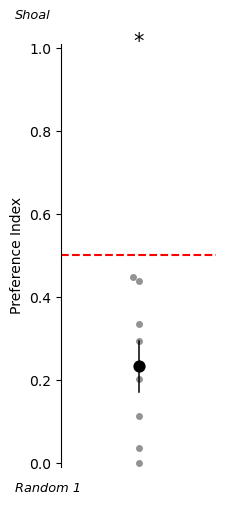

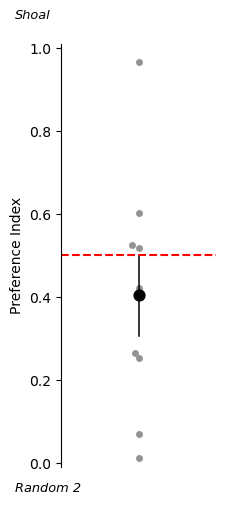

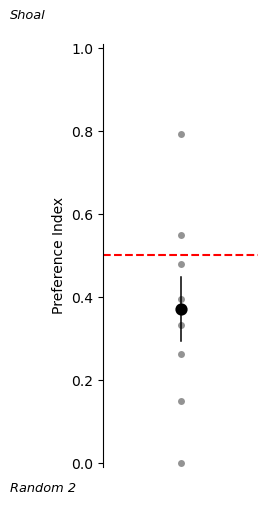

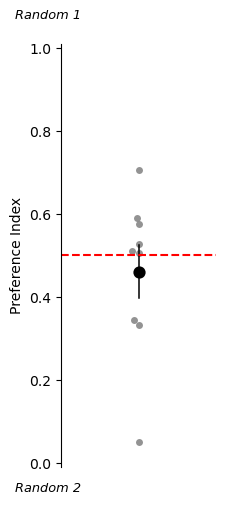

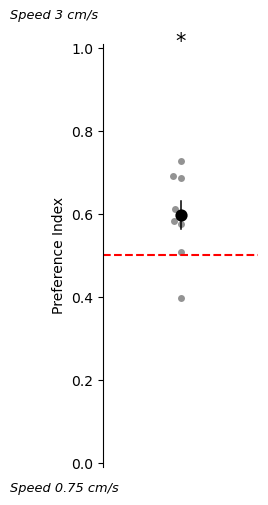

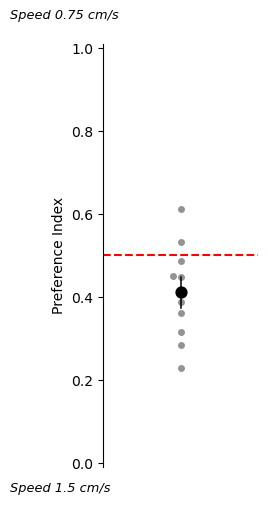

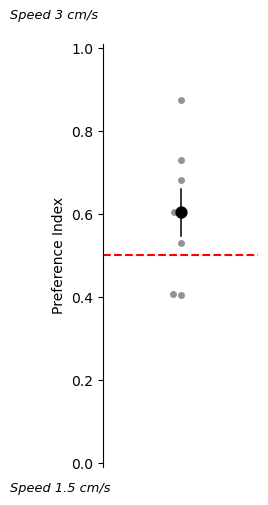

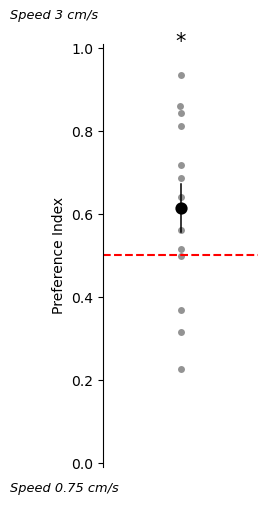

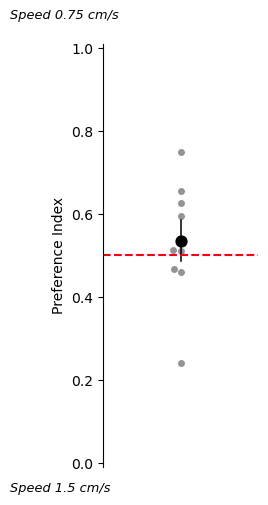

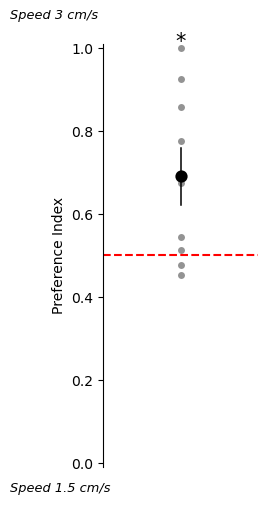

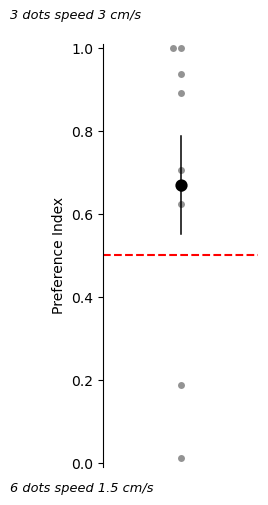

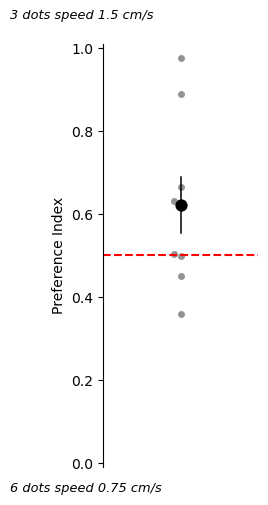

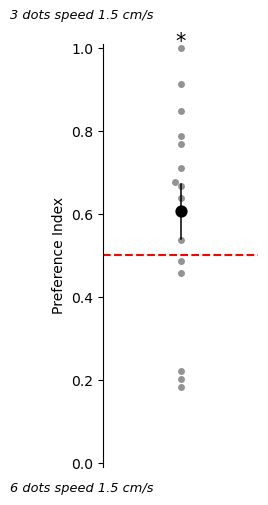

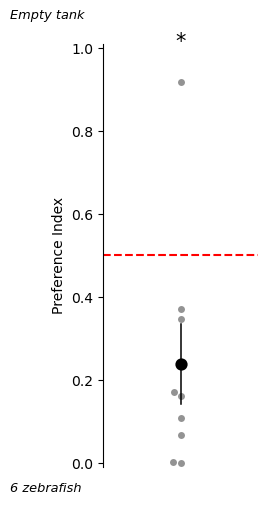

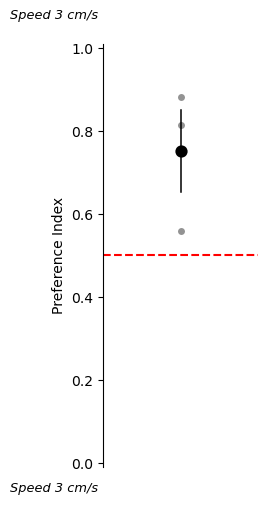

In [25]:
df_pref_idx_totsec = df_pref_idx[df_pref_idx['timepoint'] == 'tot_sec']

for group in exp_groups:
        bool_selector = ((df_pref_idx_totsec['fish_ID'].isin(selected_subj)) & 
                         (df_pref_idx_totsec['exp_group'] == group) &
                         (df_pref_idx_totsec['date'].isin(selected_dates)) &
                         (df_pref_idx_totsec['session'] == 'TEST'))
            
        data_selected = df_pref_idx_totsec[bool_selector]
        # Create the figure and axes
        f, ax = plt.subplots(figsize=(2, 5.5))

        sns.swarmplot(data=data_selected, y="pref_index", alpha=0.85, 
                                  zorder=-100, dodge=False, color='grey')


                # Create the bar plot with custom edge colors
        sns.pointplot(data=data_selected, y="pref_index", estimator='mean',
                                  errorbar="se", capsize=0, errwidth=1.1, dodge=False, color='black')
        
        # Customize the legend
        #handles, labels = ax.get_legend_handles_labels()
        #legend = ax.legend(handles[:2], labels[:2], bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
        sns.despine(bottom=True)


        # Draw a horizontal line at y = 0.5
        ax.axhline(y=0.5, color='red', linestyle='--', label='Threshold')
        
        if group in tot_time_idx_one_asterics:
            y_coord = 1
            x_coord = 0   # Adjust this value as needed to position the line in the center of two boxplots
            plt.annotate('*', xy=(x_coord, y_coord), fontsize=15, ha='center')

        elif group in pref_idx_two_asterics:
            y_coord = 1
            x_coord = 0   # Adjust this value as needed to position the line in the center of two boxplots
            plt.annotate('**', xy=(x_coord, y_coord), fontsize=17, ha='center')

                # Set labels and title
        ax.set(ylabel="Preference Index", title=f"Experiment group {group}")
        # Set y-axis label position to top
        
        exp1 = ['exp1-flock-random1', 'exp1-flock-random2','exp1-random1-random2']
        exp3 = ['exp3-n3-speed12-n6-speed6', 'exp3-n3-speed6-n6-speed3', 'exp3-n3-speed6-n6-speed6']
            
        if group in exp1:
            label_dict['flock-n6-speed6'] = 'Shoal'
        elif group in exp3:
            label_dict['flock-n6-speed6'] = '6 dots speed 1.5 cm/s'
            label_dict['flock-n6-speed3'] = '6 dots speed 0.75 cm/s'
            label_dict['flock-n3-speed12'] = '3 dots speed 3 cm/s'
            label_dict['flock-n3-speed6'] = '3 dots speed 1.5 cm/s'
        else:
            label_dict['flock-n6-speed6'] = 'Speed 1.5 cm/s'
            label_dict['flock-n6-speed3'] = 'Speed 0.75 cm/s'
            label_dict['flock-n3-speed12'] = 'Speed 3 cm/s'
            label_dict['flock-n3-speed6'] = 'Speed 1.5 cm/s'
        
        stim1 = label_dict[data_selected["stim1"].values[0]]
        stim2 = label_dict[data_selected["stim2"].values[0]]
        
        if group in exp1:
            x_text = -0.8
        else:
            x_text = -1.1
                
        ax.text(x_text, 1.07, f'{stim1}', fontsize=9.3, fontstyle='italic')
        ax.text(x_text, -0.07, f'{stim2}', fontsize=9.3, fontstyle='italic')
        ax.set_title(None)

        # Set custom y-axis tick labels
        ax.xaxis.set_ticks_position('none')
        plt.ylim(-0.01, 1.01)
        
        file_name = folder_path / f"pref-idx_{group}.pdf"
        #plt.savefig(file_name, bbox_inches='tight')

#### Preference index across time

In [ ]:
#Data for saving figures
current_date = datetime.datetime.now()
folder_name = current_date.strftime("%Y-%m-%d")
folder_path = Path(rf"F:\biodi_project\experiment_data\figures\{folder_name}\pref_idx\timepoints")
folder_path.mkdir(parents=True, exist_ok=True)


df_pref_idx_min = df_pref_idx.copy()
df_pref_idx_min = df_pref_idx_min[df_pref_idx_min['timepoint'] != 'tot_sec']

In [ ]:
mapping = {'minute1':1, 'minute2':2, 'minute3':3, 'minute4':4, 'minute5':5}
df_pref_idx_min['timepoint'] = df_pref_idx_min['timepoint'].replace(mapping)

for i, group in enumerate(exp_groups):
       
    #Select data 
    bool_selector = ((df_pref_idx_min['fish_ID'].isin(selected_subj)) & 
                     (df_pref_idx_min['date'].isin(selected_dates)) &
                     (df_pref_idx_min['exp_group'] == exp_groups[i]) &
                     (df_pref_idx_min['session'] == 'TEST'))
    
    
    df_pref_min = df_pref_idx_min[bool_selector]
    
    # Create the figure and axes
    f, ax = plt.subplots(figsize=(6, 5.5))
    
    sns.pointplot(data=df_pref_min, x="timepoint", y="pref_index", estimator='mean', errorbar="se", 
                  capsize=0, errwidth=1, dodge=False, color='black')
    
    sns.swarmplot(data=df_pref_min, x="timepoint", y="pref_index", alpha=0.6, 
                                  zorder=-100, dodge=False, color='grey')

    
    sns.despine(bottom=True)

    # Draw a horizontal line at y = 0.5
    ax.axhline(y=0.5, color='red', linestyle='--', label='Threshold')

                # Set labels and title
    ax.set(xlabel= 'Minute', ylabel="Preference Index")
    
    # Set y-axis label position to top
    ax.text(-1.7, 1.07, f'{df_pref_min["stim1"].values[0]}', fontsize=9.3, fontstyle='italic')
    ax.text(-1.7, -0.08, f'{df_pref_min["stim2"].values[0]}', fontsize=9.3, fontstyle='italic')
    ax.set_title(f"Experiment group {group}", y=1.11, fontsize=10.5)

    # Set custom y-axis tick labels
    ax.xaxis.set_ticks_position('none')
    plt.ylim(-0.01, 1.01)
    #plt.tight_layout()
    
    file_name = folder_path / f"pref-idx_timepoints_{exp_groups[i]}.pdf"
    #plt.savefig(file_name, bbox_inches='tight')
    

### Plots for checking side bias

In [ ]:
#Select experiments and fish according to specific criteria
selector = (((df_metadata['correct_experiment'] == 'yes') | (df_metadata['correct_experiment'] == 'maybe')))
            
selected_subj = set(df_metadata.loc[selector, 'fish_ID'])
selected_dates = set(df_metadata.loc[selector, 'date'])

In [ ]:
#Select experiments and fish according to specific criteria
selector = (((df_metadata['correct_experiment'] == 'yes') | (df_metadata['correct_experiment'] == 'maybe')) &
            (df_metadata['first_exp'] == 'yes') & (df_metadata['exp_name'] == 'biodi') &
            (df_metadata['session'] == 'TEST'))
            
selected_subj = set(df_metadata.loc[selector, 'fish_ID'])
selected_dates = set(df_metadata.loc[selector, 'date'])

In [ ]:
#Lists of values
exp_groups = list(sorted(set(df_data['exp_group'])))
fish_ids = list(set(df_data['fish_ID'].values))
#exp_date = list(sorted(set(df_data['date'].values)))

In [ ]:
#Dates for checking side bias across each experiment date
dates = []
for val in df_data['date'].values:
    year, month, day, hour = val.split('-')
    date = '-'.join([year, month, day])
    dates.append(date)
    
dates_set = list(sorted(set(dates)))

#### Barplot time spent near each side - grouped per experimental day

In [ ]:
current_date = datetime.datetime.now()
folder_name = current_date.strftime("%Y-%m-%d")

# Specify the parent directory where you want to create the folder
folder_path = Path(f"/Volumes/HARDISKMATI/biodi_project/figures/side_bias/{folder_name}")
folder_path.mkdir(parents=True, exist_ok=True)

In [ ]:
#Barplot for side bias
for date in dates_set:
    bool_selector = (df_data['fish_ID'].isin(selected_subj)) & (df_data['date'].str.contains(date)) & (df_data['session'] == 'HAB')
        
    if sum(bool_selector) == 0: 
        pass
    else:
        exp_tot_time = df_data[bool_selector]

        # Create the figure and axes
        f, ax = plt.subplots(figsize=(3, 3.8))
    
        swarmplot = sns.swarmplot(data=exp_tot_time, x="side", y="tot_sec", hue="side", alpha=0.85, 
                          zorder=-100, dodge=False, order=['L', 'R'], hue_order=['L', 'R'])

        
        # Create the bar plot with custom edge colors
        barplot = sns.barplot(data=exp_tot_time, x="side", y="tot_sec", hue="side", order=['L', 'R'], 
                              hue_order=['L', 'R'], errorbar="se", capsize=0, errwidth=1.3, width=0.6,
                              linewidth=1.5, alpha=0.5, dodge=False)
        
        #for fish_id in exp_tot_time['fish_ID'].unique():
            #data = exp_tot_time[exp_tot_time['fish_ID'] == fish_id]
            #sides = ['L', 'R']
            #ax.plot(data[data['side'] == 'L']['tot_sec'],  data[data['side'] == 'R']['tot_sec'], 
            #linewidth = 0.5, linestyle = '--')
            
        # Customize the legend
        handles, labels = ax.get_legend_handles_labels()
        legend = ax.legend(handles[:2], labels[:2], 
                           bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
        legend.set_title("Screen side")
        plt.margins(x=0.1)
        sns.despine(bottom=True)
    
        # Set labels and title
        ax.set(xlabel="Side", ylabel="Total seconds spent near each screen \n(without stimulus)", 
           title=f"Experiment day {date}")
        ax.xaxis.set_ticks_position('none')
        plt.ylim(-2, 310)
        
        #file_name = folder_path / f"sidebias_barplot_{date}.pdf"
        #plt.savefig(file_name, bbox_inches='tight')
        
        plt.show()

#### Boxplot time spent near each side - grouped per experimental day

In [ ]:
# Specify the parent directory where you want to create the folder
folder_path = Path(f"/Volumes/HARDISKMATI/biodi_project/figures/side_bias/{folder_name}/boxplots/")
folder_path.mkdir(parents=True, exist_ok=True)

for date in dates_set: 
    bool_selector = (df_data['fish_ID'].isin(selected_subj)) & (df_data['date'].str.contains(date)) & (df_data['session'] == 'HAB')  
    if sum(bool_selector) == 0: 
        pass
    else:
        exp_tot_time = df_data[bool_selector]
    
        # Create the figure and axes
        f, ax = plt.subplots(figsize=(3, 3.8))
    
        swarmplot = sns.swarmplot(data=exp_tot_time, x="side", y="tot_sec", hue="side", alpha=0.85, 
                          zorder=-100, dodge=False, order=['L', 'R'], hue_order=['L', 'R'])

        # Create the bar plot with custom edge colors
        boxplot = sns.boxplot(data=exp_tot_time, x="side", y="tot_sec", hue="side", order=['L', 'R'], width=0.65,
                              hue_order=['L', 'R'], dodge=False, boxprops={'edgecolor': 'None', 'alpha' : 0.3})

        # Customize the legend
        handles, labels = ax.get_legend_handles_labels()
        legend = ax.legend(handles[:2], labels[:2], bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
        legend.set_title("Screen side")
        plt.margins(x=0.1)
        sns.despine(bottom=True)
    
        # Set labels and title
        ax.set(xlabel="Side", ylabel="Total seconds spent near each screen \n(without stimulus)", 
           title=f"Experiment day {date}")
        ax.xaxis.set_ticks_position('none')
        plt.ylim(-2, 310)
        
        #file_name = folder_path / f"sidebias_boxplot_{date}.pdf"
        #plt.savefig(file_name, bbox_inches='tight')

#### Boxplot time spent near each side - grouped per experimental group

In [ ]:
# Specify the parent directory where you want to create the folder
folder_path = Path(f"/Volumes/HARDISKMATI/biodi_project/figures/side_bias/{folder_name}/boxplots/exp_groups")
folder_path.mkdir(parents=True, exist_ok=True)

for group in exp_groups:
    bool_selector = ((df_data['fish_ID'].isin(selected_subj)) & 
                     (df_data['exp_group'] == group) & 
                     (df_data['session'] == 'HAB'))
    if sum(bool_selector) == 0: 
        pass
    else:
        exp_tot_time = df_data[bool_selector]
        
        # Create the figure and axes
        f, ax = plt.subplots(figsize=(3, 3.8))
    
        swarmplot = sns.swarmplot(data=exp_tot_time, x="side", y="tot_sec", hue="side", alpha=0.85, 
                          zorder=-100, dodge=False, order=['L', 'R'], hue_order=['L', 'R'])

        # Create the bar plot with custom edge colors
        boxplot = sns.boxplot(data=exp_tot_time, x="side", y="tot_sec", hue="side", order=['L', 'R'], 
                              hue_order=['L', 'R'],dodge=False, boxprops={'edgecolor': 'None', 'alpha' : 0.3}, 
                              width=0.65)

        # Customize the legend
        handles, labels = ax.get_legend_handles_labels()
        legend = ax.legend(handles[:2], labels[:2], bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
        legend.set_title("Screen side")
        plt.margins(x=0.1)
        sns.despine(bottom=True)
    
        # Set labels and title
        ax.set(xlabel="Side", ylabel="Total seconds spent near each screen \n(without stimulus)", 
           title=f"Experiment group {group}")
        ax.xaxis.set_ticks_position('none')
        plt.ylim(-2, 310)
        
        #file_name = folder_path / f"sidebias_boxplot_{group}.pdf"
        #plt.savefig(file_name, bbox_inches='tight')

#### Barplot overall total time spent near left and right

In [ ]:
bool_selector = (df_data['fish_ID'].isin(selected_subj)) & (df_data['session'] == 'HAB')
exp_tot_time = df_data[bool_selector]

In [ ]:
folder_path = Path(f"/Volumes/HARDISKMATI/biodi_project/figures/side_bias/{folder_name}/barplots/")
folder_path.mkdir(parents=True, exist_ok=True)

f, ax = plt.subplots(figsize=(3, 4.3))

swarmplot = sns.swarmplot(data=exp_tot_time, x="side", y="tot_sec", hue="side", alpha=0.85, 
                          zorder=-100, dodge=False, order=['L', 'R'], hue_order=['L', 'R'])

barplot = sns.barplot(data=exp_tot_time, x="side", y="tot_sec", hue="side", order=['L', 'R'],hue_order=['L', 'R'],
                      errorbar="se", capsize=0, errwidth=1.3, linewidth=1.5, alpha=0.5, dodge=False)

# Customize the legend
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[:2], labels[:2], bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
legend.set_title("Screen side")
plt.margins(x=0.1)
sns.despine(bottom=True)
ax.xaxis.set_ticks_position('none')
plt.ylim(-3, 310)

# Set labels and legends
ax.set_xlabel('Side')
ax.set_ylabel('Total seconds spent near each screen \n(without stimulus)')  # Remove legend title

#file_name = folder_path / f"sidebias_barplot_allfish.pdf"
#plt.savefig(file_name, bbox_inches='tight')

#### Boxplot overall total time spent near left and right

In [ ]:
folder_path = Path(f"/Volumes/HARDISKMATI/biodi_project/figures/side_bias/{folder_name}/boxplots/")

f, ax = plt.subplots(figsize=(3, 4.3))
# Create the swarm plot

swarmplot = sns.swarmplot(data=exp_tot_time, x="side", y="tot_sec", hue="side", alpha=0.85, 
                          zorder=-100, dodge=False, order=['L', 'R'], hue_order=['L', 'R'])

boxplot = sns.boxplot(data=exp_tot_time, x="side", y="tot_sec", hue="side", order=['L', 'R'], dodge=False, 
                          boxprops={'edgecolor': 'None', 'alpha' : 0.3}, hue_order=['L', 'R'])

# Customize the legend
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[:2], labels[:2], bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
legend.set_title("Screen Side")
plt.margins(x=0.1)
sns.despine(bottom=True)
ax.xaxis.set_ticks_position('none')
plt.ylim(-3, 310)

# Set labels and legends
ax.set_xlabel('Side')
ax.set_ylabel('Total seconds spent near each screen \n(without stimulus)')  # Remove legend title

# Show the plot

#file_name = folder_path / f"sidebias_boxplot_allfish.pdf"
#plt.savefig(file_name, bbox_inches='tight')

# Statistics

#### T-test with preference index

In [26]:
df_pref_stat = df_pref_idx[df_pref_idx['timepoint'] == 'tot_sec']

bool_selector = ((df_pref_stat['fish_ID'].isin(selected_subj)) & 
                 (df_pref_stat['date'].isin(selected_dates)) &
                 (df_pref_stat['session'] == 'TEST'))
            
data_selected = df_pref_stat[bool_selector].copy()

In [27]:
pref_idx_one_asterics = []
pref_idx_two_asterics = []

for group in exp_groups:
    grouped_data = data_selected[data_selected['exp_group'] == group]
    t_test = stats.ttest_1samp(grouped_data['pref_index'], 0.5, nan_policy = 'omit')
    print(group)
    print(t_test)
    
    if t_test[1] < 0.01:
        pref_idx_two_asterics.append(group)
    elif t_test[1] < 0.05:
        pref_idx_one_asterics.append(group)

exp1-flock-random1
TtestResult(statistic=-4.356990342748809, pvalue=0.0033263680635242, df=7)
exp1-flock-random2
TtestResult(statistic=-0.9871156349981423, pvalue=0.3524964848491391, df=8)
exp1-flock-random2-speed8
TtestResult(statistic=-1.6897069344952034, pvalue=0.12955442833018377, df=8)
exp1-random1-random2
TtestResult(statistic=-0.6197553496665682, pvalue=0.5526572051866347, df=8)
exp2-n3-speed3-12
TtestResult(statistic=2.8820696466256956, pvalue=0.020446477389779557, df=8)
exp2-n3-speed3-6
TtestResult(statistic=-2.3905157089677163, pvalue=0.04052311480378138, df=9)
exp2-n3-speed6-12
TtestResult(statistic=1.830014587325359, pvalue=0.10994300330487239, df=7)
exp2-n6-speed3-12
TtestResult(statistic=1.985794894490169, pvalue=0.06856058520415667, df=13)
exp2-n6-speed3-6
TtestResult(statistic=0.7264320004581801, pvalue=0.48828094991550075, df=8)
exp2-n6-speed6-12
TtestResult(statistic=2.7711031752092663, pvalue=0.024255341316283215, df=8)
exp3-n3-speed12-n6-speed6
TtestResult(statistic

In [ ]:
pref_idx_one_asterics = ['exp2-n3-speed3-12', 'exp2-n6-speed6-12', 'exp4-realfish-empty']
pref_idx_two_asterics = 'exp1-flock-random1'

#### T-test for total time

In [28]:
numeric_columns = ['tot_sec', 'minute1', 'minute2', 'minute3', 'minute4', 'minute5']
minutes = ['minute1', 'minute2', 'minute3', 'minute4', 'minute5']

bool_selector = ((df_data['fish_ID'].isin(selected_subj)) & 
                 (df_data['date'].isin(selected_dates)) &
                 (df_data['session'] == 'TEST'))

data_selected_time = df_data[bool_selector].copy()

In [29]:
tot_time_idx_one_asterics = []
tot_time_idx_two_asterics = []

for group in exp_groups:
    grouped_data = data_selected_time[data_selected_time['exp_group'] == group]
    stimuli = np.unique(grouped_data['stimulus'])

    bool_stim1 = grouped_data['stimulus'] == stimuli[0]
    stimulus1_data = grouped_data[bool_stim1]

    bool_stim2 = grouped_data['stimulus'] == stimuli[1]
    stimulus2_data = grouped_data[bool_stim2]
    
    
    t_test = stats.ttest_rel(stimulus1_data['tot_sec'], stimulus2_data['tot_sec'], nan_policy = 'omit')
    print(group)
    print(t_test)
    
    if t_test[1] < 0.01:
        tot_time_idx_two_asterics.append(group)

    elif t_test[1] < 0.05:
        tot_time_idx_one_asterics.append(group)

exp1-flock-random1
TtestResult(statistic=-2.425437402943634, pvalue=0.045725726905420774, df=7)
exp1-flock-random2
TtestResult(statistic=0.19492922642083585, pvalue=0.8503078384304792, df=8)
exp1-flock-random2-speed8
TtestResult(statistic=-2.1094420469007913, pvalue=0.06793225831143916, df=8)
exp1-random1-random2
TtestResult(statistic=-0.9414817254679753, pvalue=0.3740142749394594, df=8)
exp2-n3-speed3-12
TtestResult(statistic=3.178810284883095, pvalue=0.013020771122004306, df=8)
exp2-n3-speed3-6
TtestResult(statistic=-2.546812507040904, pvalue=0.03135831126427355, df=9)
exp2-n3-speed6-12
TtestResult(statistic=2.1807465336090597, pvalue=0.06556840622763788, df=7)
exp2-n6-speed3-12
TtestResult(statistic=2.4559924974211778, pvalue=0.028885804459995567, df=13)
exp2-n6-speed3-6
TtestResult(statistic=0.11306541172458111, pvalue=0.9127644818230747, df=8)
exp2-n6-speed6-12
TtestResult(statistic=2.413863681492798, pvalue=0.04225270006809583, df=8)
exp3-n3-speed12-n6-speed6
TtestResult(statisti

In [ ]:
tot_time_idx_one_asterics = ['exp1-flock-random1', 'exp2-n3-speed3-12', 'exp2-n6-speed3-12',
                             'exp2-n6-speed6-12', 'exp3-n3-speed6-n6-speed6', 'exp4-realfish-empty']

#### t-test across minutes

In [ ]:
for group in exp_groups:
    grouped_data = data_selected_time[data_selected_time['exp_group'] == group]
    stimuli = np.unique(grouped_data['stimulus'])

    bool_stim1 = grouped_data['stimulus'] == stimuli[0]
    stimulus1_data = grouped_data[bool_stim1]

    bool_stim2 = grouped_data['stimulus'] == stimuli[1]
    stimulus2_data = grouped_data[bool_stim2]
    
    for minute in minutes:
        t_test = stats.ttest_rel(stimulus1_data[minute], 
                                 stimulus2_data[minute], nan_policy = 'omit')
        print(group, minute)
        print(t_test)

### Plotting results

#### Plots for side bias

In [ ]:
#Select experiments and fish according to specific criteria
selector = (((df_metadata['correct_experiment'] == 'yes') | (df_metadata['correct_experiment'] == 'maybe')))
            
selected_subj = set(df_metadata.loc[selector, 'fish_ID'])
selected_dates = set(df_metadata.loc[selector, 'date'])

In [ ]:
#Lists of values
exp_groups = list(sorted(set(df_data['exp_group'])))
fish_ids = list(set(df_data['fish_ID'].values))
#exp_date = list(sorted(set(df_data['date'].values)))

In [ ]:
#Dates for checking side bias across each experiment date
dates = []
for val in df_data['date'].values:
    year, month, day, hour = val.split('-')
    date = '-'.join([year, month, day])
    dates.append(date)
    
dates_set = list(sorted(set(dates)))

In [ ]:
current_date = datetime.datetime.now()
folder_name = current_date.strftime("%Y-%m-%d")

# Specify the parent directory where you want to create the folder
folder_path = Path(f"/Volumes/HARDISKMATI/biodi_project/figures/side_bias/{folder_name}")
folder_path.mkdir(parents=True, exist_ok=True)

In [ ]:
#Barplot for side bias
for date in dates_set:
    bool_selector = (df_data['fish_ID'].isin(selected_subj)) & (df_data['date'].str.contains(date)) & (df_data['session'] == 'HAB')
        
    if sum(bool_selector) == 0: 
        pass
    else:
        exp_tot_time = df_data[bool_selector]

        # Create the figure and axes
        f, ax = plt.subplots(figsize=(3, 3.8))
    
        swarmplot = sns.swarmplot(data=exp_tot_time, x="side", y="tot_sec", hue="side", alpha=0.85, 
                          zorder=-100, dodge=False, order=['L', 'R'], hue_order=['L', 'R'])

        
        # Create the bar plot with custom edge colors
        barplot = sns.barplot(data=exp_tot_time, x="side", y="tot_sec", hue="side", order=['L', 'R'], 
                              hue_order=['L', 'R'], errorbar="se", capsize=0, errwidth=1.3, width=0.6,
                              linewidth=1.5, alpha=0.5, dodge=False)

        # Customize the legend
        handles, labels = ax.get_legend_handles_labels()
        legend = ax.legend(handles[:2], labels[:2], 
                           bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
        legend.set_title("Screen side")
        plt.margins(x=0.1)
        sns.despine(bottom=True)
    
        # Set labels and title
        ax.set(xlabel="Side", ylabel="Total seconds spent near each screen \n(without stimulus)", 
           title=f"Experiment day {date}")
        ax.xaxis.set_ticks_position('none')
        plt.ylim(-2, 310)
        
        #file_name = folder_path / f"sidebias_barplot_{date}.pdf"
        #plt.savefig(file_name, bbox_inches='tight')
        
        plt.show()

In [ ]:
# Specify the parent directory where you want to create the folder
folder_path = Path(f"/Volumes/HARDISKMATI/biodi_project/figures/side_bias/{folder_name}/boxplots/")
folder_path.mkdir(parents=True, exist_ok=True)

for date in dates_set: 
    bool_selector = (df_data['fish_ID'].isin(selected_subj)) & (df_data['date'].str.contains(date)) & (df_data['session'] == 'HAB')  
    if sum(bool_selector) == 0: 
        pass
    else:
        exp_tot_time = df_data[bool_selector]
    
        # Create the figure and axes
        f, ax = plt.subplots(figsize=(3, 3.8))
    
        swarmplot = sns.swarmplot(data=exp_tot_time, x="side", y="tot_sec", hue="side", alpha=0.85, 
                          zorder=-100, dodge=False, order=['L', 'R'], hue_order=['L', 'R'])

        # Create the bar plot with custom edge colors
        boxplot = sns.boxplot(data=exp_tot_time, x="side", y="tot_sec", hue="side", order=['L', 'R'], width=0.65,
                              hue_order=['L', 'R'], dodge=False, boxprops={'edgecolor': 'None', 'alpha' : 0.3})

        # Customize the legend
        handles, labels = ax.get_legend_handles_labels()
        legend = ax.legend(handles[:2], labels[:2], bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
        legend.set_title("Screen side")
        plt.margins(x=0.1)
        sns.despine(bottom=True)
    
        # Set labels and title
        ax.set(xlabel="Side", ylabel="Total seconds spent near each screen \n(without stimulus)", 
           title=f"Experiment day {date}")
        ax.xaxis.set_ticks_position('none')
        plt.ylim(-2, 310)
        
        #file_name = folder_path / f"sidebias_boxplot_{date}.pdf"
        #plt.savefig(file_name, bbox_inches='tight')

In [ ]:
# Specify the parent directory where you want to create the folder
folder_path = Path(f"/Volumes/HARDISKMATI/biodi_project/figures/side_bias/{folder_name}/boxplots/exp_groups")
folder_path.mkdir(parents=True, exist_ok=True)

for group in exp_groups:
    bool_selector = ((df_data['fish_ID'].isin(selected_subj)) & 
                     (df_data['exp_group'] == group) & 
                     (df_data['session'] == 'HAB'))
    if sum(bool_selector) == 0: 
        pass
    else:
        exp_tot_time = df_data[bool_selector]
        
        # Create the figure and axes
        f, ax = plt.subplots(figsize=(3, 3.8))
    
        swarmplot = sns.swarmplot(data=exp_tot_time, x="side", y="tot_sec", hue="side", alpha=0.85, 
                          zorder=-100, dodge=False, order=['L', 'R'], hue_order=['L', 'R'])

        # Create the bar plot with custom edge colors
        boxplot = sns.boxplot(data=exp_tot_time, x="side", y="tot_sec", hue="side", order=['L', 'R'], 
                              hue_order=['L', 'R'],dodge=False, boxprops={'edgecolor': 'None', 'alpha' : 0.3}, 
                              width=0.65)

        # Customize the legend
        handles, labels = ax.get_legend_handles_labels()
        legend = ax.legend(handles[:2], labels[:2], bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
        legend.set_title("Screen side")
        plt.margins(x=0.1)
        sns.despine(bottom=True)
    
        # Set labels and title
        ax.set(xlabel="Side", ylabel="Total seconds spent near each screen \n(without stimulus)", 
           title=f"Experiment group {group}")
        ax.xaxis.set_ticks_position('none')
        plt.ylim(-2, 310)
        
        #file_name = folder_path / f"sidebias_boxplot_{group}.pdf"
        #plt.savefig(file_name, bbox_inches='tight')

In [ ]:
bool_selector = (df_data['fish_ID'].isin(selected_subj)) & (df_data['session'] == 'HAB')
exp_tot_time = df_data[bool_selector]

In [ ]:
folder_path = Path(f"/Volumes/HARDISKMATI/biodi_project/figures/side_bias/{folder_name}/barplots/")
folder_path.mkdir(parents=True, exist_ok=True)

f, ax = plt.subplots(figsize=(3, 4.3))

swarmplot = sns.swarmplot(data=exp_tot_time, x="side", y="tot_sec", hue="side", alpha=0.85, 
                          zorder=-100, dodge=False, order=['L', 'R'], hue_order=['L', 'R'])

barplot = sns.barplot(data=exp_tot_time, x="side", y="tot_sec", hue="side", order=['L', 'R'],hue_order=['L', 'R'],
                      errorbar="se", capsize=0, errwidth=1.3, linewidth=1.5, alpha=0.5, dodge=False)

# Customize the legend
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[:2], labels[:2], bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
legend.set_title("Screen side")
plt.margins(x=0.1)
sns.despine(bottom=True)
ax.xaxis.set_ticks_position('none')
plt.ylim(-3, 310)

# Set labels and legends
ax.set_xlabel('Side')
ax.set_ylabel('Total seconds spent near each screen \n(without stimulus)')  # Remove legend title

#file_name = folder_path / f"sidebias_barplot_allfish.pdf"
#plt.savefig(file_name, bbox_inches='tight')

In [ ]:
folder_path = Path(f"/Volumes/HARDISKMATI/biodi_project/figures/side_bias/{folder_name}/boxplots/")

f, ax = plt.subplots(figsize=(3, 4.3))
# Create the swarm plot

swarmplot = sns.swarmplot(data=exp_tot_time, x="side", y="tot_sec", hue="side", alpha=0.85, 
                          zorder=-100, dodge=False, order=['L', 'R'], hue_order=['L', 'R'])

boxplot = sns.boxplot(data=exp_tot_time, x="side", y="tot_sec", hue="side", order=['L', 'R'], dodge=False, 
                          boxprops={'edgecolor': 'None', 'alpha' : 0.3}, hue_order=['L', 'R'])

# Customize the legend
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[:2], labels[:2], bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
legend.set_title("Screen Side")
plt.margins(x=0.1)
sns.despine(bottom=True)
ax.xaxis.set_ticks_position('none')
plt.ylim(-3, 310)

# Set labels and legends
ax.set_xlabel('Side')
ax.set_ylabel('Total seconds spent near each screen \n(without stimulus)')  # Remove legend title

# Show the plot

#file_name = folder_path / f"sidebias_boxplot_allfish.pdf"
#plt.savefig(file_name, bbox_inches='tight')